In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'


!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision
!pip install livelossplot
    
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from livelossplot import PlotLosses

tcmalloc: large alloc 1073750016 bytes == 0x57172000 @  0x7f38e2dd01c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /root/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot


Using TensorFlow backend.


In [2]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset=tv.datasets.CIFAR10(
    root='.data/',
    train=True,
    download=True,
    transform=transform
)

trainloader=t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

In [3]:
testset=tv.datasets.CIFAR10(
    root='.data/',
    train=False,
    download=True,
    transform=transform
)

testloader=t.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

classes=('plane','car','bird','cat','deer',
        'dog','frog','horse','ship','truck')

Files already downloaded and verified


In [4]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

print(device)

cuda:0


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,32,3)
        self.norm1=nn.BatchNorm2d(32)
        self.pool1=nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2=nn.Conv2d(32,64,3)
        self.norm2=nn.BatchNorm2d(64)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1=nn.Linear(1600,1000)
        self.fc2=nn.Linear(1000,500)
        self.fc3=nn.Linear(500,10)
        
  
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.norm1(x)
        x=self.pool1(x)
        x=F.relu(self.conv2(x))
        x=self.norm2(x)
        x=self.pool2(x)
        x=x.view(x.size()[0],-1)
        x=F.dropout(self.fc1(x),p=0.3)
        x=F.relu(x)
        x=F.dropout(self.fc2(x),p=0.3)
        x=F.relu(x)
        x=self.fc3(x)
        
        return x

net=Net()
net=net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
)


In [0]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)

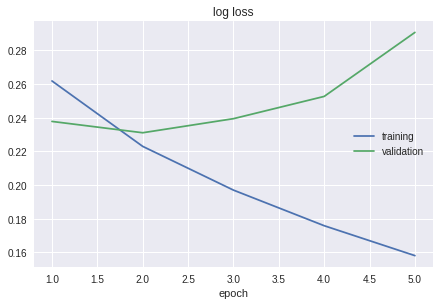

In [8]:
liveloss=PlotLosses()

for epoch in range(5):
    
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_loss_val = 0.0
    epoch_correct_val = 0
    
    net.train()
    for i , data in enumerate(trainloader,0):
        inputs, labels=data
        inputs, labels=Variable(inputs),Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data[0]
               
    avg_loss = epoch_loss / len(trainloader.dataset)
    
    
    net.eval()
    for data in testloader:
        images, labels=data
        images, labels = images.to(device), labels.to(device)
    
        outputs=net(Variable(images))
        loss = criterion(outputs, labels)

        epoch_loss_val += loss.data[0]
    
    avg_loss_val = epoch_loss_val / len(testloader.dataset)
    
    liveloss.update({
        'log loss': avg_loss,
        'val_log loss': avg_loss_val
    })
    liveloss.draw()       

In [9]:
correct=0
total=0

net.eval()
for data in testloader:
    images, labels=data
    images, labels = images.to(device), labels.to(device)
    
    outputs=net(Variable(images))
    _, predicted=t.max(outputs.data, 1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum()
    
print('10000張測試集中的準確率為: {} %'.format(100*correct/total))

10000張測試集中的準確率為: 71 %
